## XGBoost notebook

After preprocessing and feature engineering, we use Optuna to determine hyperparameters for our XGBoost model.  It produces a RMSLE of 0.05922, which is 1324/4318 in the Kaggle competition.  For explainability, we examine feature importance, residual plots, and SHAP values.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb
import seaborn as sns
import optuna
import shap

In [2]:
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


In [3]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, id+calories removed, and sex as categorical variable
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])
    
    
    df_new['Sex'] = df_new['Sex'].astype('category')

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)
    df_new['Body_Temp_-_min_sq'] = (df_new['Body_Temp']-df_new['Body_Temp'].min())**2

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

Use Optuna for hyperparameter selection.

In [ ]:
y = np.log1p(train['Calories'])
X = add_feats(train, numerical_features)

def objective(trial):
    
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset. (not supported on GPU)
        # "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": "gbtree",
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": 0.8,
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        # use GPU
        'device': 'cuda',
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth": trial.suggest_int("max_depth", 6, 12, step=2),
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
        "eta": trial.suggest_float("eta", 0.005, 0.3, step=0.005),
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
    }


    # Cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=724)
    
    scores = []

    # Perform cross-validation manually
    for train_idx, valid_idx in kf.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]
        
        # Create Dataset for validation to enable early stopping
        dtrain = xgb.DMatrix(X_tr, label=y_tr, enable_categorical=True)
        dtest = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

        # Initialize and train the model with the suggested hyperparameters
        # Use high boost rounds that will more than likely be stopped by early stopping rounds
        model = xgb.train(param, dtrain, num_boost_round=2000,
                          evals=[(dtrain, 'train'), (dtest, 'eval')], early_stopping_rounds=40, verbose_eval=False)
        
        # print("Stopped at iteration:", model.best_iteration)

        # evaluate using only the best trees
        predictions = model.predict(dtest, iteration_range=(0, model.best_iteration))
        
        # Calculate the score
        score = rmse(y_val, predictions)
        scores.append(score)
    

    # Calculate mean RMSE
    error = np.mean(scores)
    return error


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize", study_name='xgb_early_stop', storage="sqlite:///xgboost.db", load_if_exists=True)
    study.optimize(objective, n_trials=1000, timeout=32400)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2025-06-21 00:14:24,977] Using an existing study with name 'xgb_early_stop' instead of creating a new one.
[I 2025-06-21 00:14:49,200] Trial 9 finished with value: 0.061219332440238076 and parameters: {'lambda': 0.00011525058811261093, 'alpha': 0.004891218885390323, 'colsample_bytree': 0.8733338270030928, 'max_depth': 10, 'min_child_weight': 6, 'eta': 0.185, 'gamma': 0.002241366618090038, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.060233872664862236.
[I 2025-06-21 00:17:03,498] Trial 10 finished with value: 0.06077308600955677 and parameters: {'lambda': 3.065149536508135e-07, 'alpha': 4.25226289106054e-06, 'colsample_bytree': 0.9877868151049276, 'max_depth': 12, 'min_child_weight': 2, 'eta': 0.015, 'gamma': 4.910916560961253e-08, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 0.060233872664862236.
[I 2025-06-21 00:17:30,685] Trial 11 finished with value: 0.06086967711041103 and parameters: {'lambda': 1.57897212944105e-08, 'alpha': 0.9504682648140133, 'colsa

Number of finished trials:  397
Best trial:
  Value: 0.059627947228760136
  Params: 
    lambda: 3.3114171034258904e-07
    alpha: 0.38248641585385146
    colsample_bytree: 0.39042420143740825
    max_depth: 8
    min_child_weight: 5
    eta: 0.01
    gamma: 4.368583054801034e-05
    grow_policy: depthwise


c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:57:38] WARNING: D:\bld\xgboost-split_1744329010901\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Stopped at iteration: 1568
Train prediction: 0.05428598438025143
Test prediction: 0.059537940428256206


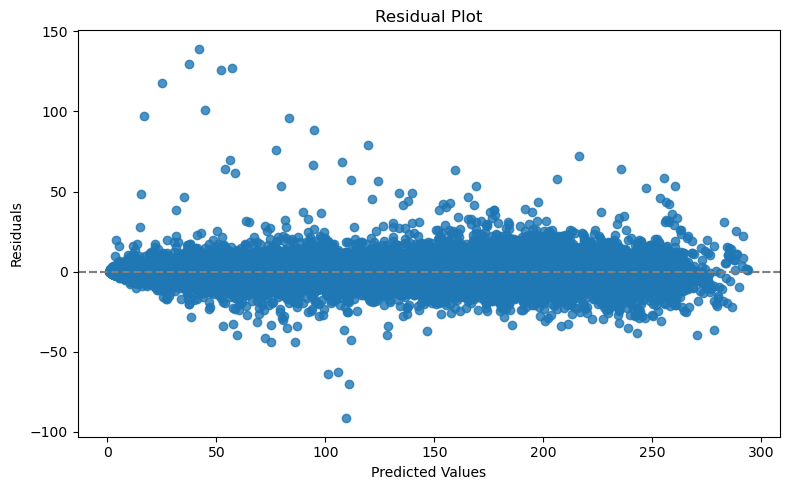

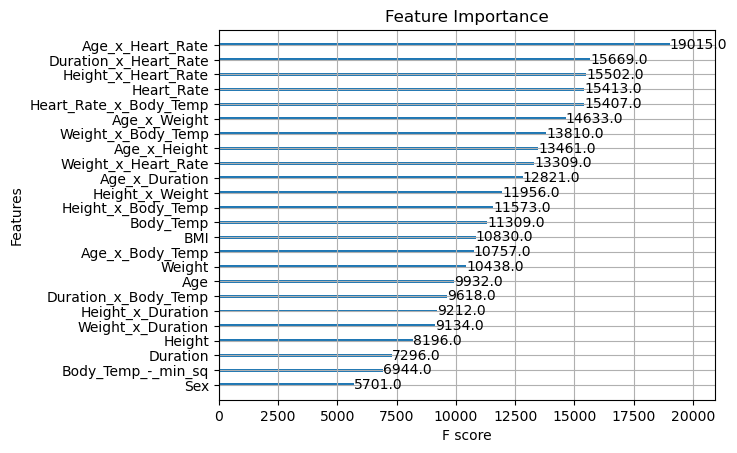

       id    Calories
0  750000   27.389458
1  750001  107.993576
2  750002   87.801491
3  750003  125.841881
4  750004   75.616859

count    250000.000000
mean         88.171562
std          62.256687
min           0.965487
25%          33.999431
50%          76.462791
75%         135.449554
max         292.705078
Name: Calories, dtype: float64


In [4]:
# Kaggle score 0.05922 pub, 0.05751 priv, xgb_prediction_15.csv (1324/4318)

# Best trial:
#   Value: 0.059627947228760136
#   Params: 
#     lambda: 3.3114171034258904e-07
#     alpha: 0.38248641585385146
#     colsample_bytree: 0.39042420143740825
#     max_depth: 8
#     min_child_weight: 5
#     eta: 0.01
#     gamma: 4.368583054801034e-05
#     grow_policy: depthwise

y = np.log1p(train['Calories'])
X = add_feats(train, numerical_features)

# Encode Sex categorical feature to be compatable with SHAP
encoder = OrdinalEncoder()

X_enc = X.copy()
X_enc['Sex'] = encoder.fit_transform(X[['Sex']])

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=724)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters
param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset. (not supported on GPU)
        # "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": "gbtree",
        # L2 regularization weight.
        "lambda": 3.3114171034258904e-07,
        # L1 regularization weight.
        "alpha": 0.38248641585385146,
        # sampling ratio for training data.
        "subsample": 0.8,
        # sampling according to each tree.
        "colsample_bytree": 0.39042420143740825,
        # use GPU
        'device': 'cuda',
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth": 8,
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight": 5,
        "eta": 0.01,
        # defines how selective algorithm is.
        "gamma": 4.368583054801034e-05,
        "grow_policy": "depthwise",
    }

# Initialize and train the model with the suggested hyperparameters
model = xgb.train(param, dtrain, num_boost_round=2000,
                        evals=[(dtrain, 'train'), (dtest, 'eval')], early_stopping_rounds=40, verbose_eval=False)
        
print("Stopped at iteration:", model.best_iteration)

# Make predictions, using the best model after early stopping
train_pred = model.predict(dtrain, iteration_range=(0, model.best_iteration))
test_pred = model.predict(dtest, iteration_range=(0, model.best_iteration))

# Ensure non-negative predictions (important for RMSLE)
train_pred[train_pred < 0] = 1
train_pred[train_pred > 320] = 300
test_pred[test_pred < 0] = 1
test_pred[test_pred > 320] = 300

print("Train prediction:", rmse(train_pred, y_train))
print("Test prediction:", rmse(test_pred, y_test))


# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(test_pred), y=np.expm1(y_test))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


# Get feature importance scores
# By default or in this example, the importance type is 'weight' - frequency that the feature is used
importance = model.get_score(importance_type='weight')

# Sort the importance dictionary by importance value
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)


# Plot feature importance using xgboost's built-in plot_importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()



# make the submission file!
testsub = add_feats(test, numerical_features)
testsub['Sex'] = encoder.fit_transform(testsub[['Sex']])

pred = model.predict(xgb.DMatrix(testsub), iteration_range=(0, model.best_iteration))

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("xgb_prediction_15.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

### SHAP values for explainability

Which features contribute most to the models performance?

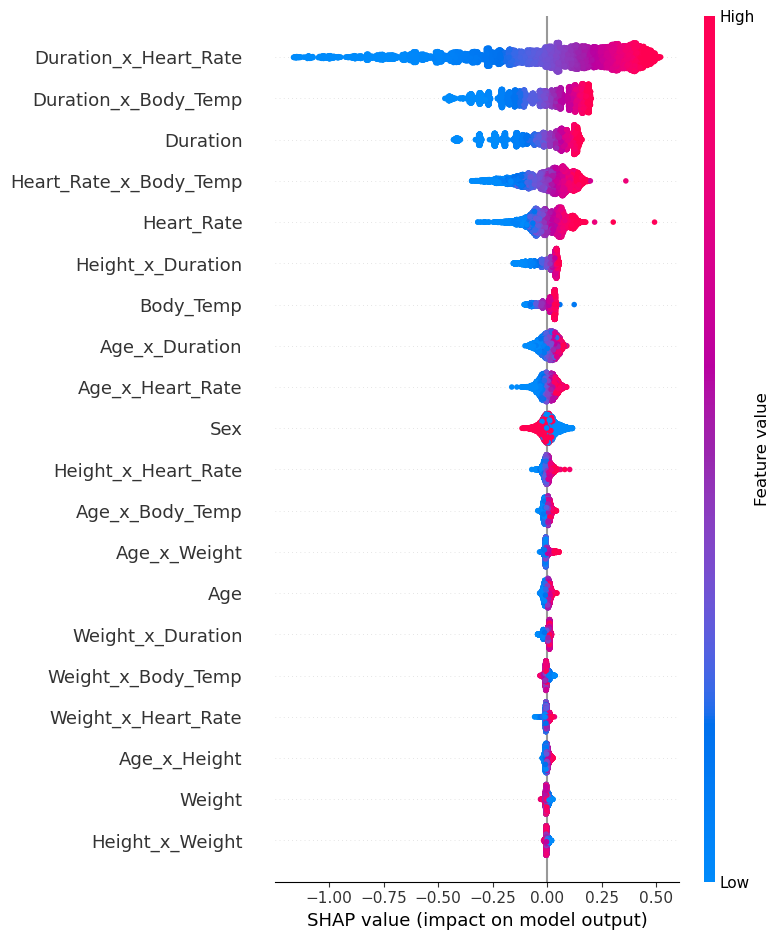

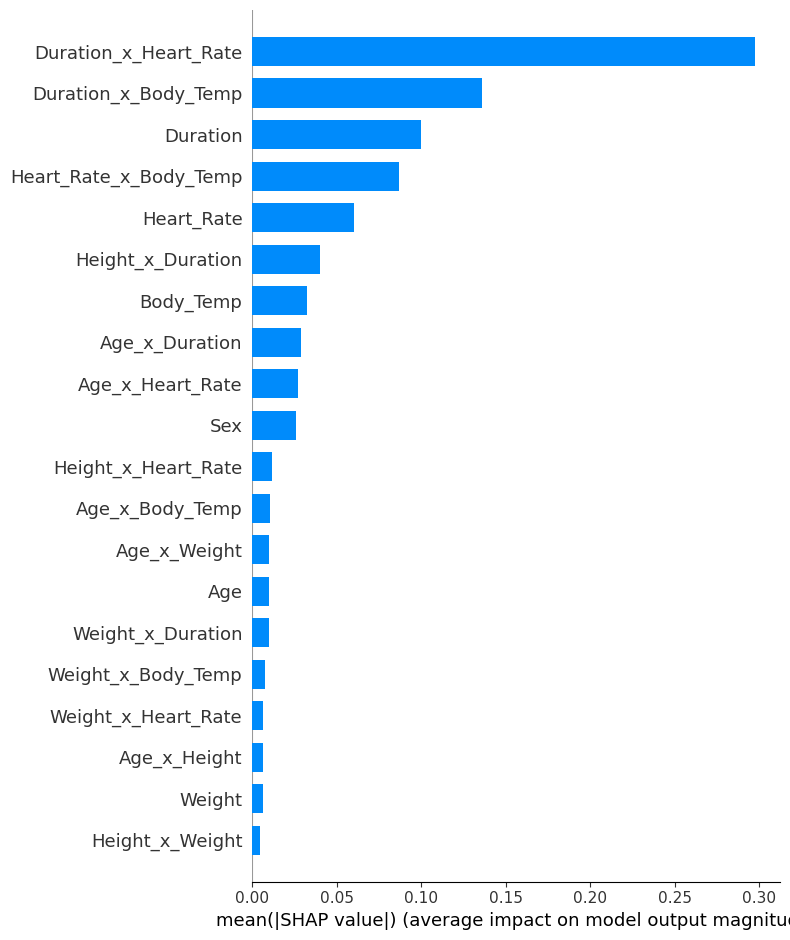

In [5]:
explainer  = shap.TreeExplainer(model)

# compute SHAP on 10000-point sample
X_small    = X_train.sample(10000, random_state=724)
shap_vals  = explainer.shap_values(X_small)

# visualize
shap.summary_plot(shap_vals, X_small)
shap.summary_plot(shap_vals, X_small, plot_type='bar')

#### SHAP Dependence plots

How are features related?

In this plot, we can see that Duration and Heart_Rate appear to be related; as Duration increases, so does Heart_Rate, and the SHAP values.

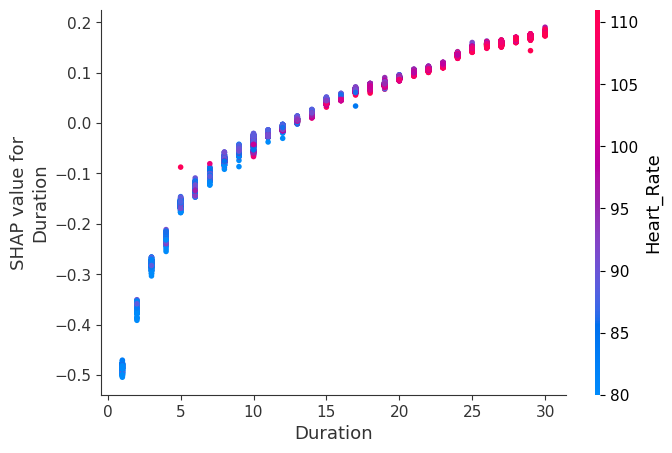

In [ ]:
shap.dependence_plot(
    'Duration',
    shap_vals,
    X_small,
   interaction_index='Heart_Rate'  # name or index of the feature to color by
)

We can see the relation between Duration_x_Heart_Rate and increases SHAP values.  Moreover, it appears that Sex (red for male) and Duration_x_Heart_Rate have no relation.

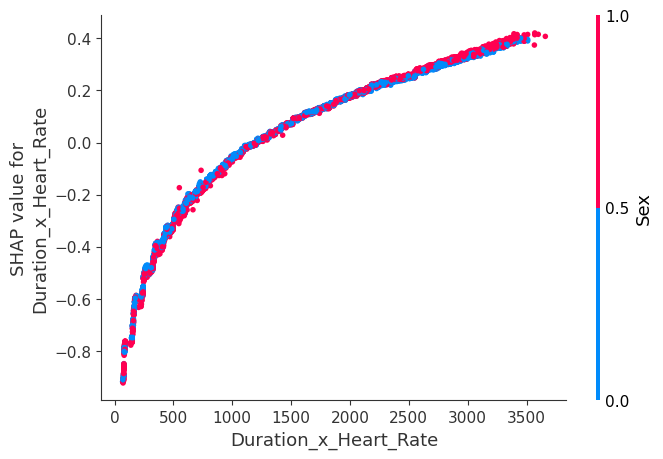

In [25]:
shap.dependence_plot(
    'Duration_x_Heart_Rate',
    shap_vals,
    X_small,
   interaction_index='Sex'  # name or index of the feature to color by
)

We can see that Age has little effect on SHAP values (notice the scale).

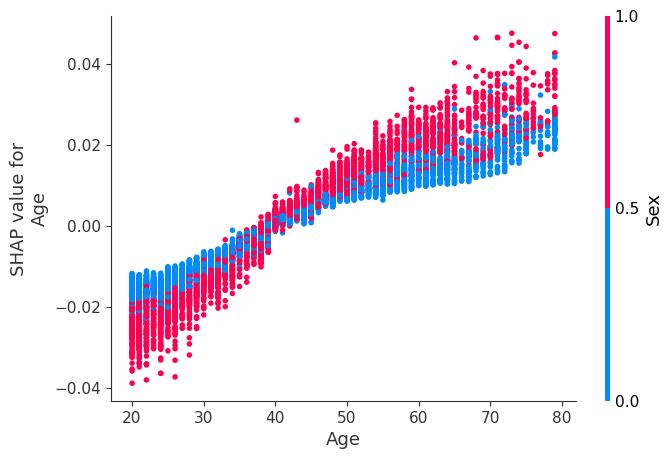

In [32]:
shap.dependence_plot(
    'Age',
    shap_vals,
    X_small,
   interaction_index='Sex'  # name or index of the feature to color by
)

#### SHAP waterfall plots

Below, $E[f(X)]$ is the mean value of the log-transformed Calories in our sample of the dataset and $f(x)$ is the predicted value of (log-transformed) Calories for the $i^{\mathrm{th}}$ entry of our dataset.  The red/blue arrows with a number inside represent that features impact on the difference between the mean value and predicted value.

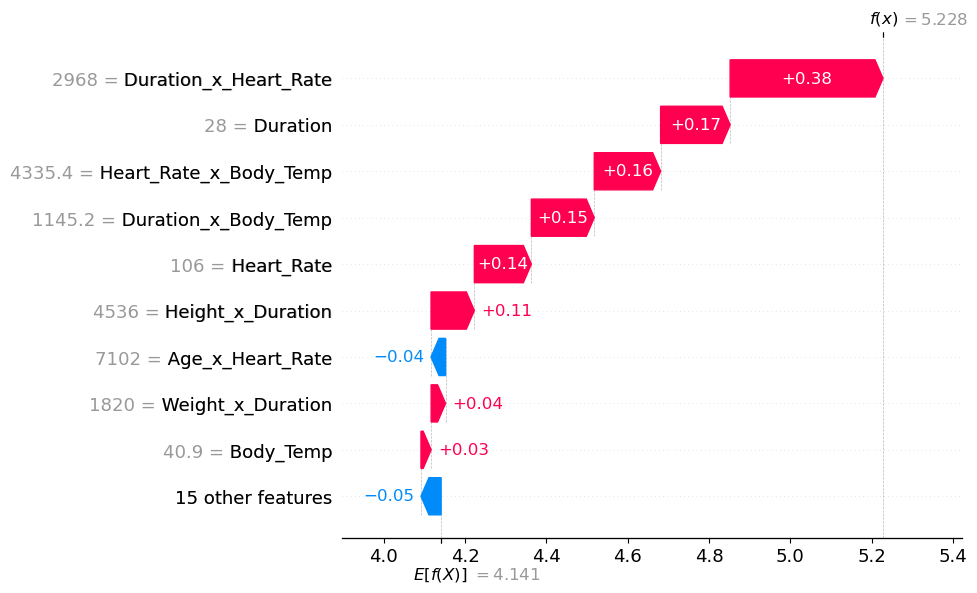

In [21]:
i = 0

shap.plots.waterfall(
    shap.Explanation(
      values=shap_vals[i], 
      base_values=explainer.expected_value, 
      data=X_test.iloc[i]
    )
)

In [11]:
shap.initjs()  # initialize JS visualizations in notebooks

# Show the force plot for one prediction
shap.force_plot(
    explainer.expected_value,
    shap_vals[0:10],
    X_test.iloc[0:10],
    # matplotlib=True  # use `matplotlib=True` for static plot or remove for interactive
)
